In [1]:
#!/usr/bin/env python
# coding: utf-8

import re, os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pctk import multicellds 


In [2]:

# modules_path = os.path.dirname(os.path.realpath(__file__))
# modules_path = os.path.join(modules_path, 'modules')
# sys.path.append(modules_path)
# from multicellds import MultiCellDS

def get_timeserie_mean(mcds, filter_alive=True):
    time = []
    values = []
    filter_alive = True
    for t, df in mcds.cells_as_frames_iterator():
        time.append(t)
        df = df.iloc[:,3:]
        if filter_alive:
            mask = df['current_phase'] <= 14
            df = df[mask]
        values.append(df.mean(axis=0).values)
        # if filter_alive:
        #     # Fix: Use boolean indexing properly
        #     mask = (df['current_phase'].astype(float) <= 14).values  # Convert to numeric and create boolean mask
        #     df = df[mask]
        # if len(df) > 0:  # Check if any cells remain after filtering
        #     values.append(df.mean(axis=0).values)
        # else:
        #     # Handle empty dataframe case
        #     empty_values = np.zeros(len(df.columns))
        #     values.append(empty_values)

    cell_columns = df.columns.tolist()
    df = pd.DataFrame(values, columns=cell_columns)
    df['time'] = time
    return df[['time'] + cell_columns]


def get_timeserie_density(mcds):
    data = []
    for t,m in mcds.microenvironment_as_matrix_iterator():
        data.append((t, m[5,:].sum()))
    df = pd.DataFrame(data=data, columns=['time', 'drug_A_internal_density'])
    return df

def plot_molecular_model(df_cell_variables, list_of_variables, ax1):

    threshold = 0.5

    for label in list_of_variables:
        y = df_cell_variables[label]
        time = df_cell_variables["time"]
        ax1.plot(time, y, label="% X " + label)

    ax1.set_ylabel("% X")
    ax1.yaxis.grid(True)
    # ax1.set_xlim((0,time.values[-1]))
    # ax1.set_ylim((0,1))
    # ax1.set_xlabel("time (min)")
    
def plot_cells(df_time_course, color_dict, ax):

    # Alive/Apoptotic/Necrotic vs Time
    for k in color_dict:
        ax.plot(df_time_course.time, df_time_course[k], "-", c=color_dict[k], label=k)
    
    # setting axes labels
    # ax.set_xlabel("time (min)")
    ax.set_ylabel("Number of cells")
    
    # Showing legend
    ax.legend()
    ax.yaxis.grid(True)

In [14]:
name = "output"

color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}

instance_folder = "../../../../"
# instance_folder = sys.argv[1]

data_folder = instance_folder + name

phases_dict = multicellds.default_phases_dict
phase_grouping = multicellds.default_phase_grouping


# Globing output files according to the output format specified
# if args.format == 'physicell':
phase_col = "current_phase"
mcds = multicellds.MultiCellDS(output_folder=data_folder)
df_iterator = mcds.cells_as_frames_iterator()
num_of_files = mcds.cells_file_count()
# elif args.format == 'physiboss':
#     phase_col = "phase"
#     df_iterator = pb_output_iterator(args.data_folder)
#     num_of_files = count_pb_files(args.data_folder)

# Initializing a Pandas Databrafe to store the data
columns = ["time", "alive", "apoptotic", "necrotic"]
data = np.zeros((num_of_files, 4), dtype=int)
df_time_course = pd.DataFrame(columns=columns, data=data)

# Iterating over all cell_output files
for i, (t, df) in enumerate(df_iterator):
    print("\tProcessing time step: %.0f" % t)

    # Rename the phases integer codes using the phases_dict as the mapping
    s = df[phase_col]
    s.replace(to_replace=phases_dict, inplace=True)
    
    # Count the number of cells in each phase
    counts = s.value_counts()

    df_time_course.loc[i, 'time'] = t
    # group the previous phases count into the three general classes:
    # Alive, Apoptotic, Necrotic
    for k, v in counts.to_dict().items():
        if k not in phase_grouping:
            continue
        df_time_course.loc[i, phase_grouping[k]] += v

	Processing time step: 0
	Processing time step: 30
	Processing time step: 60
	Processing time step: 90
	Processing time step: 120
	Processing time step: 150
	Processing time step: 180
	Processing time step: 210
	Processing time step: 240
	Processing time step: 270
	Processing time step: 300
	Processing time step: 330
	Processing time step: 360
	Processing time step: 390
	Processing time step: 420
	Processing time step: 450


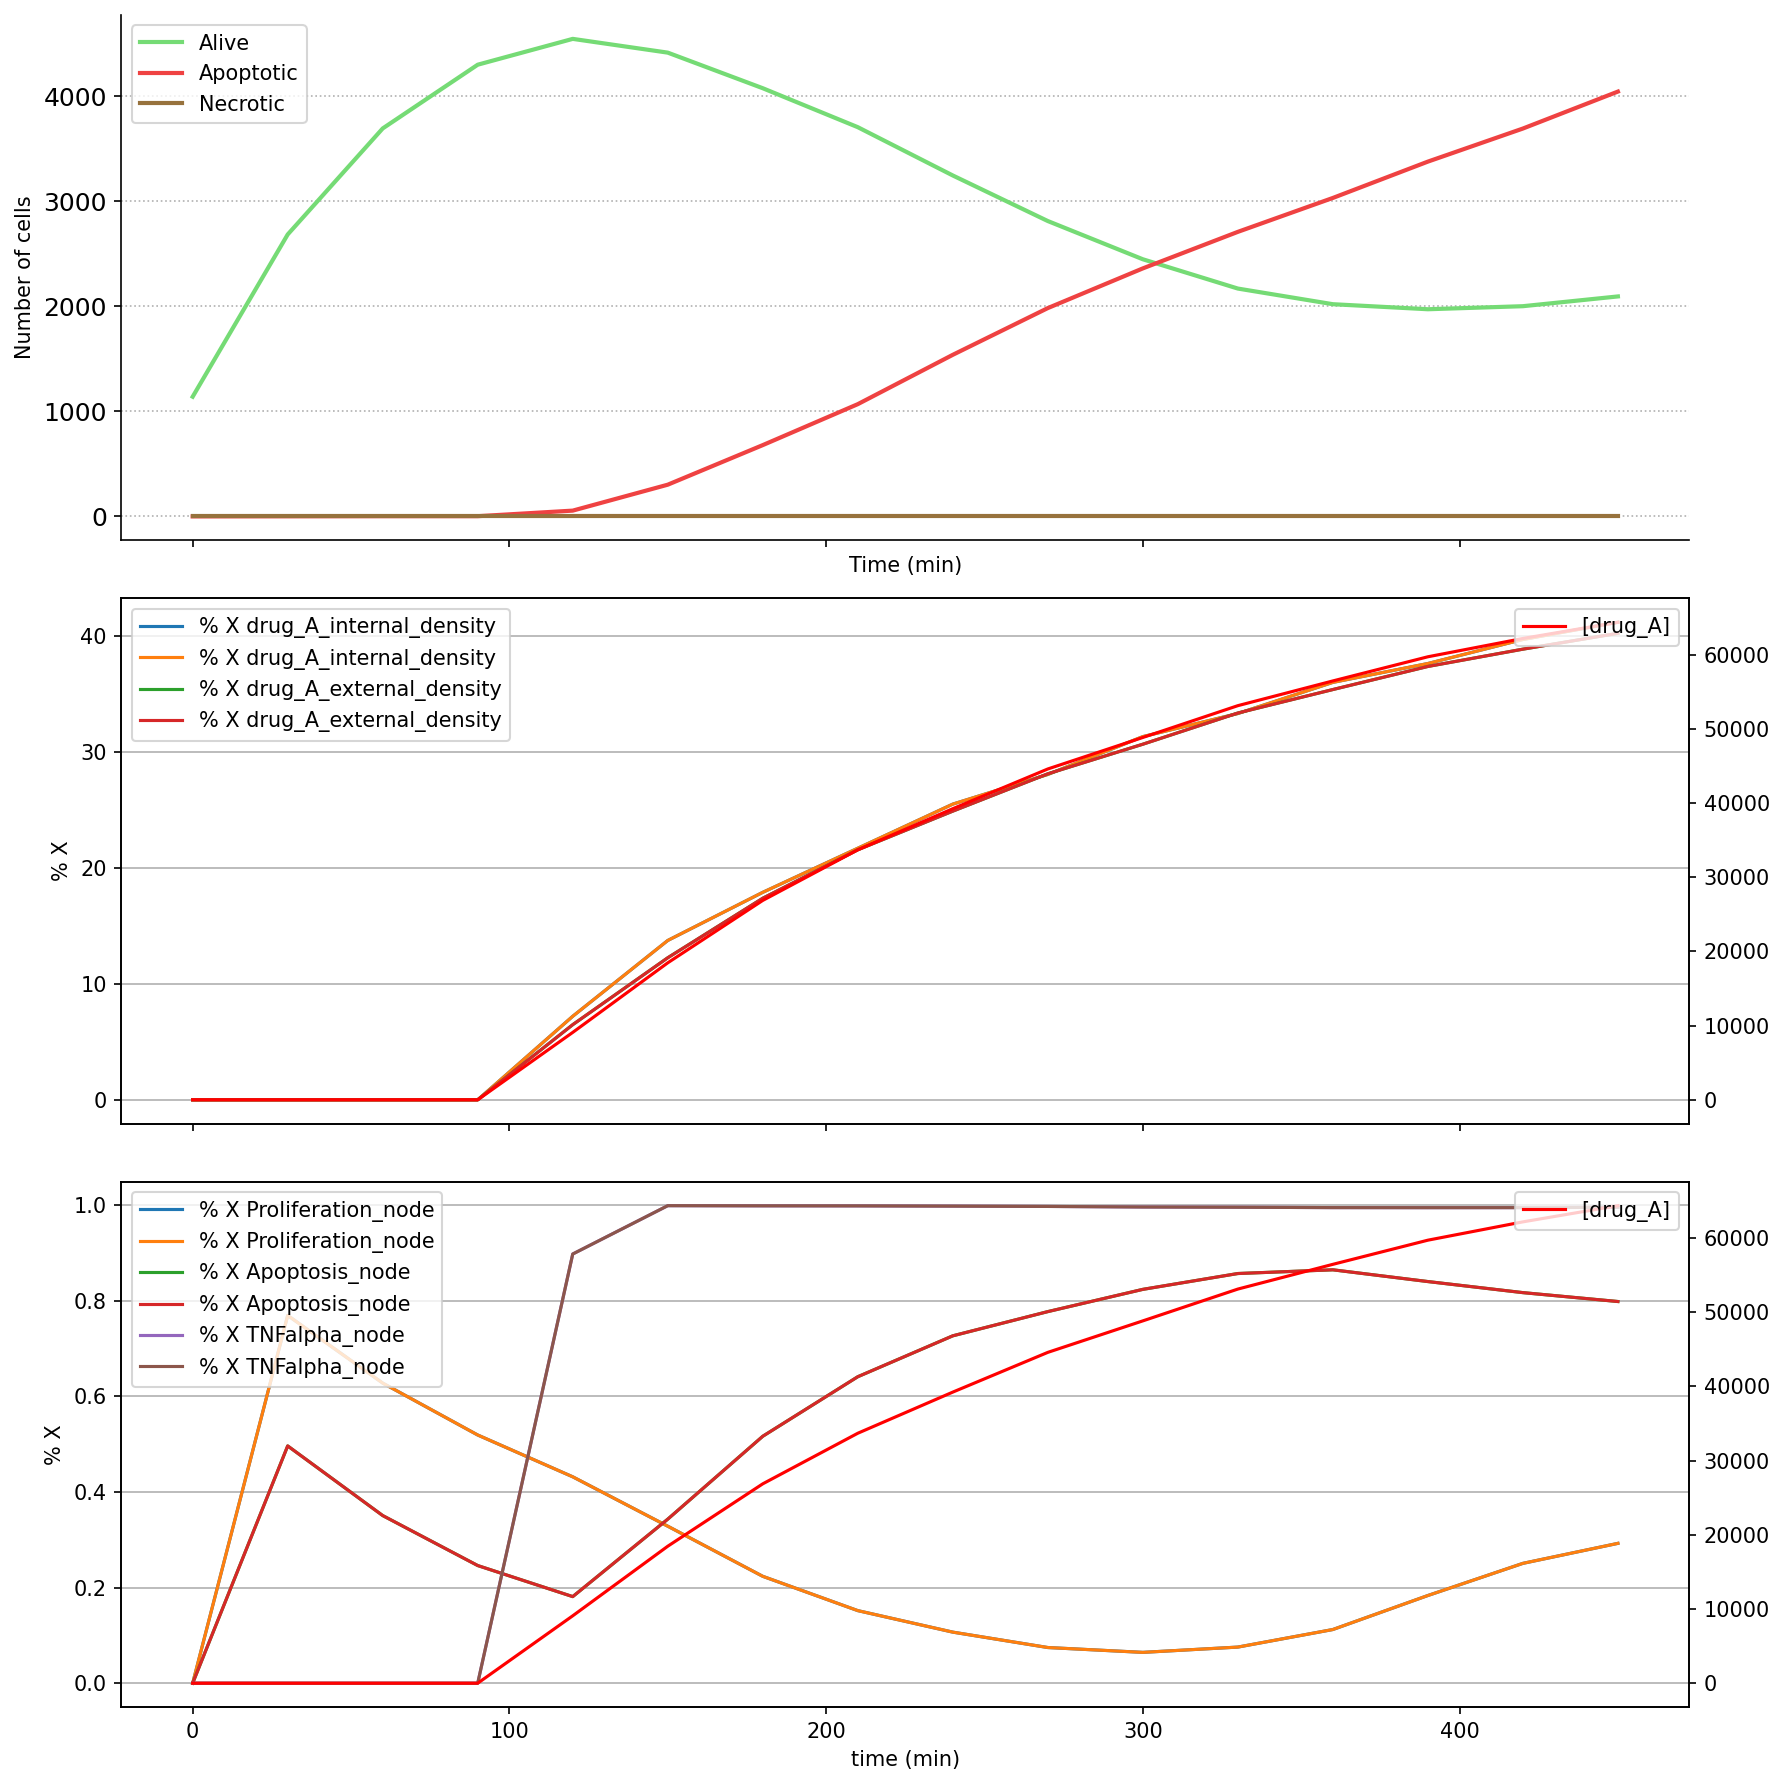

In [15]:
name = "output"

color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}

instance_folder = "../../../../"
# instance_folder = sys.argv[1]

output_data = instance_folder + name

mcds = multicellds.MultiCellDS(output_folder=output_data)

# df_time_course = mcds.get_cells_summary_frame()
df_cell_variables = get_timeserie_mean(mcds)
df_time_tnf = get_timeserie_density(mcds)

# df_time_course.to_csv(instance_folder + name + "_time_course.tsv", sep="\t")
# df_cell_variables.to_csv(instance_folder + name + "_cell_variables.tsv", sep="\t")
# df_time_tnf.to_csv(instance_folder + name + "_tnf_time.tsv", sep="\t")

fig, axes = plt.subplots(3, 1, figsize=(12,12), dpi=150, sharex=True)
# plot_cells(df_time_course, color_dict, axes[0])
curve_params = {}
curve_params['alive'] = {'color': '#75db75', 'label': 'Alive'}
curve_params['apoptotic'] = {'color': '#ef4242', 'label': 'Apoptotic'}
curve_params['necrotic'] = {'color':'#97723d', 'label': 'Necrotic'}
line_width = 2.
for k,pdict in curve_params.items():
    c = pdict['color']
    l = pdict['label']
    axes[0].plot(df_time_course.time, df_time_course[k], "-", c=c, label=l, linewidth=line_width)

# setting axes labels
axes[0].set_xlabel("Time (min)")
axes[0].set_ylabel("Number of cells")

axes[0].tick_params(axis='x', labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

# Showing legend
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].yaxis.grid(linestyle='dotted')
axes[0].legend()


list_of_variables = ['drug_A_internal_density', 'drug_A_external_density']
plot_molecular_model(df_cell_variables, list_of_variables, axes[1])
threshold = 0.5

# axes[1].hlines(threshold, 0, df_time_course.time.iloc[-1], label="Activation threshold")
ax2 = axes[1].twinx()
ax2.plot(df_time_tnf.time, df_time_tnf['drug_A_internal_density'], 'r', label="[drug_A]")
# ax2.set_ylabel("[TNF]")
# ax2.set_ylim([0, 1000])
axes[1].legend(loc="upper left")
ax2.legend(loc="upper right")

list_of_variables = ['Proliferation_node', 'Apoptosis_node', 'TNFalpha_node']
plot_molecular_model(df_cell_variables, list_of_variables, axes[2])
axes[2].set_xlabel("time (min)")
ax2 = axes[2].twinx()
ax2.plot(df_time_tnf.time, df_time_tnf['drug_A_internal_density'], 'r', label="[drug_A]")
# ax2.set_ylabel("[TNF]")
# ax2.set_ylim([0, 1000])
axes[2].legend(loc="upper left")
ax2.legend(loc="upper right")

fig.tight_layout()
# fig.savefig(instance_folder + name + "_variables_vs_time.png")

In [ ]:
name = "output"

color_dict = {"alive": "g", "apoptotic": "r", "necrotic":"k"}

instance_folder = "../../../../"
# instance_folder = sys.argv[1]

output_data = instance_folder + name

mcds = multicellds.MultiCellDS(output_folder=output_data)


time = []
values = []
filter_alive = True
for t, df in mcds.cells_as_frames_iterator():
    time.append(t)
    df = df.iloc[:,3:]
    if filter_alive:
        mask = df['current_phase'] <= 14
        df = df[mask]
    values.append(df.mean(axis=0).values)

cell_columns = df.columns.tolist()
df = pd.DataFrame(values, columns=cell_columns)
df['time'] = time
df[['time'] + cell_columns]




In [ ]:
data = []
for t,m in mcds.microenvironment_as_matrix_iterator():
    data.append((t, m[5,:].sum()))
df = pd.DataFrame(data=data, columns=['time', 'drug_A_internal_density'])
df